# Wavelet Denoising

This numerical tour uses wavelets to perform non-linear
image denoising.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$


*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.

In [1]:
using PyPlot
using NtToolBox
using Autoreload
arequire("NtToolBox")

  likely near C:\Users\Ayman\.julia\v0.5\Autoreload\src\constants.jl:1
  likely near C:\Users\Ayman\.julia\v0.5\Autoreload\src\constants.jl:1
  likely near C:\Users\Ayman\.julia\v0.5\Autoreload\src\constants.jl:7
  likely near C:\Users\Ayman\.julia\v0.5\Autoreload\src\constants.jl:7
  likely near C:\Users\Ayman\.julia\v0.5\Autoreload\src\constants.jl:12
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  likely near In[1]:4
  like

## Image Denoising

We consider a simple generative model of noisy images $F = f_0+W$
where $f_0 \in \RR^N$ is a deterministic image of $N$ pixels, and
$W$ is a Gaussian white noise distributed according to $\Nn(0,\si^2
\text{Id}_N)$, where $\si^2$ is the variance of noise.

The goal of denoising is to define an estimator $\tilde F$ of
$f_0$ that depends only on $F$, i.e. $\tilde F = \phi(F)$
where $\phi : \RR^N \rightarrow \RR^N$ is a potentially non-linear
mapping.

Note that while $f_0$ is a deterministic image, both $F$ and $\tilde F$
are random variables (hence the capital letters). 

The goal of denoising is to reduce as much as possible the denoising
error given some prior knowledge on the (unknown) image $f_0$.
A mathematical way to measure this error is to bound the 
quadratic risk $\EE_w(\norm{\tilde F - f_0}^2)$, where the expectation is computed
with respect to the distribution of the noise $W$.

Image loading and adding Gaussian Noise
For real life applications, one does not have access to the underlying
image $f_0$. In this tour, we however assume that $f_0$ is known, and
$f = f_0 + w\in \RR^N$ is generated using a single realization of the noise $w$
that is drawn from $W$. We define the estimated deterministic image as 
$\tilde f = \phi(f)$ which is a realization of the random vector
$\tilde F$.


First we load an image $f_0 \in \RR^N$ where $N=n \times n$ is the number of pixels, and then display it.

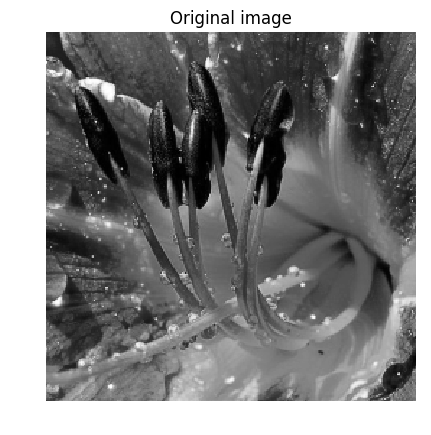

  likely near C:\Users\Ayman\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Ayman\.julia\v0.5\IJulia\src\kernel.jl:31


PyObject <matplotlib.text.Text object at 0x000000001E560BE0>

  likely near C:\Users\Ayman\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Ayman\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Ayman\.julia\v0.5\IJulia\src\kernel.jl:31
  likely near C:\Users\Ayman\.julia\v0.5\IJulia\src\kernel.jl:31


In [2]:
n = 256
name = "NtToolBox/src/data/flowers.png"
f0 = load_image(name, n)
imageplot(f0, "Original image")

Standard deviation $\si$ of the noise.

In [3]:
sigma = .08;

0.08

Then we add Gaussian noise $w$ to obtain $f=f_0+w$.

In [4]:
using Distributions
f = f0 + sigma.*rand(Normal(), size(f0)[1], size(f0)[2]);

256×256 Array{Float64,2}:
 0.197767  -0.0257282  -0.0123759  …  0.155727  0.0529168  0.325971
 0.145914   0.13758     0.224535      0.400507  0.294812   0.476433
 0.368774   0.155882    0.162269      0.426328  0.472055   0.437452
 0.179438   0.361938    0.176758      0.213828  0.463064   0.495666
 0.374562   0.104094    0.0776449     0.494927  0.460137   0.339856
 0.250857   0.202362    0.351659   …  0.357698  0.451573   0.50062 
 0.301836   0.134737    0.122904      0.34439   0.286502   0.555476
 0.294692   0.165099    0.335817      0.445586  0.485572   0.498635
 0.138957   0.174414    0.188458      0.326686  0.383657   0.391858
 0.224599   0.255533    0.0750932     0.282518  0.230207   0.357829
 0.238367   0.177058    0.0318645  …  0.355176  0.446526   0.214903
 0.151098   0.0564628   0.0627512     0.370991  0.405262   0.295054
 0.260319   0.20488     0.199456      0.389186  0.307049   0.223367
 ⋮                                 ⋱                       ⋮       
 0.331763   0.618939  

Display the noisy image. 

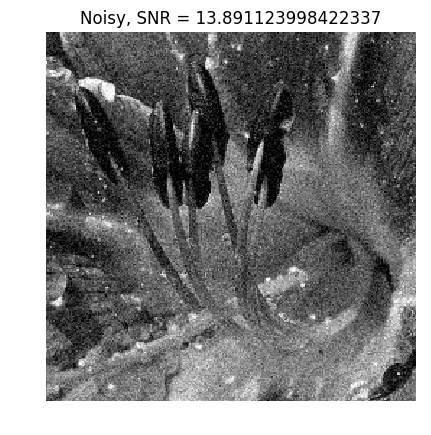

PyObject <matplotlib.text.Text object at 0x000000001EA53BE0>

In [5]:
imageplot(clamP(f), string("Noisy, SNR = ", string(snr(f0,f)) ))

## Hard Thresholding in Wavelet Bases

A simple but efficient non-linear denoising estimator is obtained by
thresholding the coefficients of $f$ in a well chosen orthogonal basis
$\Bb = \{\psi_m\}_m$ of $\RR^N$.

In the following, we will focuss on a wavelet basis, which is efficient
to denoise piecewise regular images.

The hard thresholding operator with threshold $T \geq 0$ applied to
some image $f$ is defined as
$$ S_T^0(f) = \sum_{\abs{\dotp{f}{\psi_m}}>T} \dotp{f}{\psi_m} \psi_m
       = \sum_m s_T^0(\dotp{f}{\psi_m}) \psi_m $$
where the hard thresholding operator is
$$
      s_T^0(\alpha) = \choice{
           \alpha \qifq \abs{\al}>T, \\
              0 \quad\text{otherwise}.
      }$
$$


The denoising estimator is then defined as
$$ \tilde f = S_T^0(f). $$

Display the function $s_T^0(\al)$ for $T=1$.

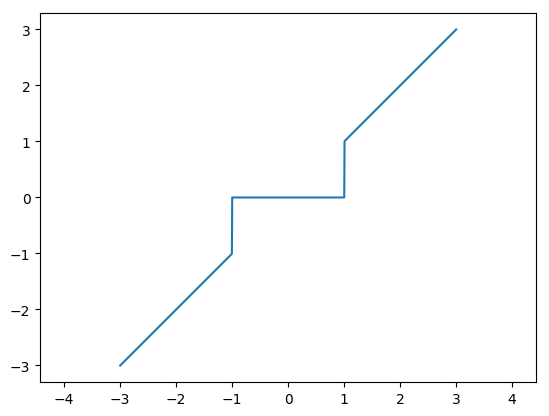

(-3.3,3.3,-3.3,3.3)

In [6]:
thresh_hard = (u, t) -> u.*(abs(u) .> t)
alpha = linspace(-3, 3, 1000)
plot(alpha, thresh_hard(alpha, 1))
axis("equal")

Parameters for the orthogonal wavelet transform.

In [7]:
h = [0, .482962913145, .836516303738, .224143868042, -.129409522551]
h = h./norm(h)
Jmin = 2;

2

First we compute the wavelet coefficients $a$  
of the noisy image $f$.

In [8]:
a = perform_wavortho_transf(f, Jmin, +1, h);

256×256 Array{Float64,2}:
 23.4035      23.9434      18.6651     20.8802     …  -0.0239512  -0.00379351
 13.6463      11.6067      18.1772     21.5199        -0.0969946  -0.108897  
 22.2646      25.0427      25.4722     22.0171        -0.050527   -0.00184625
 22.4718      29.6727      31.877      31.1387         0.0458331  -0.19704   
  3.22785      6.40001      7.23699     4.83712        0.148291   -0.022583  
  3.11166     -1.17377     -3.8898     -2.72662    …   0.0121031  -0.120415  
 -1.20608     -3.05126      3.84766     2.25332        0.20346     0.0258831 
 -0.354801    -3.08171     -1.56658    -2.78607       -0.178324   -0.0722417 
  3.07279      0.941851     1.33727     2.39148       -0.0102324   0.110471  
  0.0659434   -1.93395      0.147604    0.850266       0.0182762  -0.19824   
 -2.2519      -1.40219      2.87214    -0.402418   …  -0.106667   -0.236115  
  0.718093    -0.68511     -1.51707    -1.67147       -0.119698    0.167171  
  0.866697    -1.2731       1.44171   

Display the noisy coefficients.

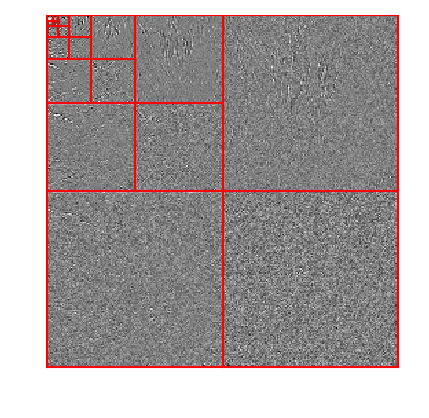

In [9]:
plot_wavelet(a, Jmin);

Select the threshold value, that should be proportional to the noise
level $\si$.

In [10]:
T = 3*sigma;

0.24

Hard threshold the coefficients below the noise level to obtain $a_T(m)=s_T^0(a_m)$.

In [11]:
aT = thresh_hard(a, T);

256×256 Array{Float64,2}:
 23.4035    23.9434    18.6651    …  -0.0   0.0   0.0       -0.0  -0.0
 13.6463    11.6067    18.1772        0.0  -0.0  -0.0       -0.0  -0.0
 22.2646    25.0427    25.4722        0.0  -0.0   0.0       -0.0  -0.0
 22.4718    29.6727    31.877         0.0  -0.0  -0.0        0.0  -0.0
  3.22785    6.40001    7.23699       0.0  -0.0   0.0        0.0  -0.0
  3.11166   -1.17377   -3.8898    …  -0.0   0.0  -0.0        0.0  -0.0
 -1.20608   -3.05126    3.84766      -0.0  -0.0  -0.309199   0.0   0.0
 -0.354801  -3.08171   -1.56658      -0.0  -0.0   0.0       -0.0  -0.0
  3.07279    0.941851   1.33727       0.0  -0.0   0.0       -0.0   0.0
  0.0       -1.93395    0.0           0.0   0.0   0.0        0.0  -0.0
 -2.2519    -1.40219    2.87214   …  -0.0   0.0   0.0       -0.0  -0.0
  0.718093  -0.68511   -1.51707       0.0   0.0   0.0       -0.0   0.0
  0.866697  -1.2731     1.44171      -0.0  -0.0   0.0       -0.0   0.0
  ⋮                               ⋱                

Display the thresholded coefficients.

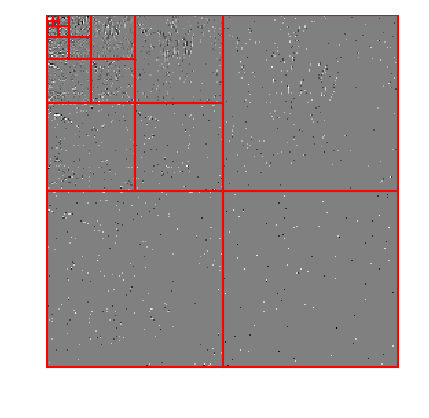

In [12]:
plot_wavelet(aT, Jmin);

Reconstruct the image $\tilde f$ from these noisy coefficients.

In [13]:
fHard = perform_wavortho_transf(aT, Jmin, -1, h);

256×256 Array{Float64,2}:
 0.162248  0.163464  0.183791  0.132795  …  0.230035  0.0966428  0.42836 
 0.199594  0.190882  0.198369  0.145405     0.318773  0.221399   0.386235
 0.240359  0.218564  0.210504  0.151183     0.440793  0.390459   0.323647
 0.268364  0.245265  0.231756  0.182457     0.438602  0.394172   0.337426
 0.324586  0.294644  0.267607  0.229726     0.438543  0.42047    0.332178
 0.275504  0.25939   0.24897   0.217299  …  0.43053   0.36248    0.397938
 0.212396  0.216528  0.231738  0.205605     0.424056  0.271152   0.525785
 0.201633  0.202059  0.209261  0.191175     0.411837  0.304244   0.421922
 0.190936  0.185799  0.181536  0.17401      0.393872  0.349106   0.281461
 0.179994  0.176223  0.173392  0.167054     0.397351  0.350038   0.277585
 0.168208  0.164992  0.162682  0.156992  …  0.397035  0.347501   0.271225
 0.159576  0.159941  0.16155   0.158516     0.41088   0.357907   0.274139
 0.154099  0.161071  0.169998  0.171625     0.438887  0.381256   0.286327
 ⋮          

Display the denoising result.

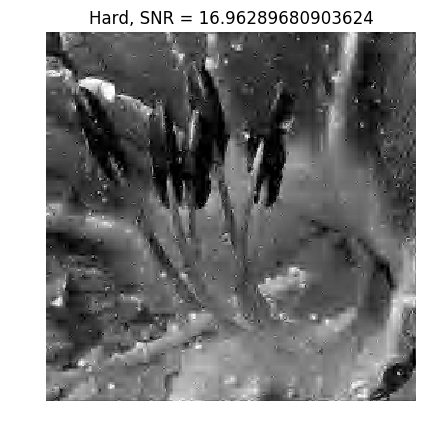

PyObject <matplotlib.text.Text object at 0x0000000027583588>

In [14]:
imageplot(clamP(fHard), string("Hard, SNR = ", string(snr(f0, fHard))) )

## Wavelet Denoising with Soft Thesholding

The estimated image $\tilde f$ using hard thresholding.
suffers from many artifacts. It is
possible to improve the result by using soft thresholding, 
defined as
$$ \tilde f = S_T^1(f) = \sum_m s_T^1(\dotp{f}{\psi_m}) \psi_m $$
$$
      \qwhereq
      s_T^1(\alpha) = \max\pa{0, 1 - \frac{T}{\abs{\alpha}}}\alpha.
$$

Display the soft thresholding function $s_T^1(\al)$.

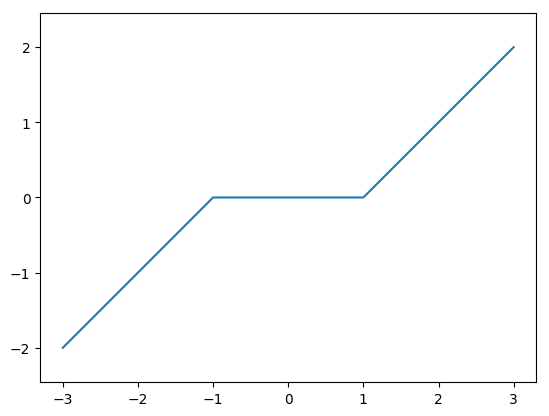

In [15]:
thresh_soft = (u, t) -> max(1 - t./abs(u), 0).*u
alpha = linspace(-3, 3, 1000)
plot(alpha, thresh_soft(alpha, 1))
axis("equal");

Select the threshold.

In [16]:
T = 3/2*sigma;

0.12

Perform the soft thresholding.

In [17]:
aT = thresh_soft(a, T);

256×256 Array{Float64,2}:
 23.2835      23.8234      18.5451     …  -0.0         -0.0        
 13.5263      11.4867      18.0572        -0.0         -0.0        
 22.1446      24.9227      25.3522        -0.0         -0.0        
 22.3518      29.5527      31.757          0.0         -0.0770398  
  3.10785      6.28001      7.11699        0.0282908   -0.0        
  2.99166     -1.05377     -3.7698     …   0.0         -0.000415364
 -1.08608     -2.93126      3.72766        0.08346      0.0        
 -0.234801    -2.96171     -1.44658       -0.0583237   -0.0        
  2.95279      0.821851     1.21727       -0.0          0.0        
  0.0         -1.81395      0.0276036      0.0         -0.0782404  
 -2.1319      -1.28219      2.75214    …  -0.0         -0.116115   
  0.598093    -0.56511     -1.39707       -0.0          0.0471708  
  0.746697    -1.1531       1.32171       -0.08175      0.0607038  
  ⋮                                    ⋱                ⋮          
 -0.0          0.00827

To slightly improve the soft thresholding performance, we do not
threshold the coefficients corresponding to coarse scale wavelets. 

In [18]:
aT[1:2^Jmin, 1:2^Jmin] = a[1:2^Jmin, 1:2^Jmin];

4×4 Array{Float64,2}:
 23.4035  23.9434  18.6651  20.8802
 13.6463  11.6067  18.1772  21.5199
 22.2646  25.0427  25.4722  22.0171
 22.4718  29.6727  31.877   31.1387

Re-construct the soft thresholding estimator $\tilde f$.

In [19]:
fSoft = perform_wavortho_transf(aT, Jmin, -1, h);

256×256 Array{Float64,2}:
 0.17342   0.172939  0.180234  0.158508  …  0.255154  0.199273  0.372073
 0.220494  0.214632  0.219834  0.18375      0.367321  0.278738  0.359332
 0.31405   0.223571  0.256948  0.20457      0.393764  0.382782  0.339736
 0.2457    0.334712  0.228548  0.198712     0.365888  0.395095  0.345723
 0.306345  0.244577  0.230353  0.213414     0.410374  0.41148   0.332919
 0.262049  0.253532  0.294156  0.252261  …  0.392707  0.38587   0.374777
 0.23185   0.221291  0.208176  0.204602     0.361887  0.34105   0.45209 
 0.216931  0.225198  0.242314  0.226402     0.380157  0.36792   0.397082
 0.211362  0.208991  0.204999  0.207057     0.379989  0.343004  0.286999
 0.206785  0.205693  0.202387  0.207343     0.372409  0.339608  0.283301
 0.200998  0.201812  0.199364  0.20909   …  0.381969  0.345516  0.284561
 0.199728  0.200107  0.197878  0.20538      0.384736  0.34371   0.282915
 0.200235  0.205325  0.212106  0.212574     0.372693  0.346922  0.285712
 ⋮                       

Display the soft thresholding denoising result.

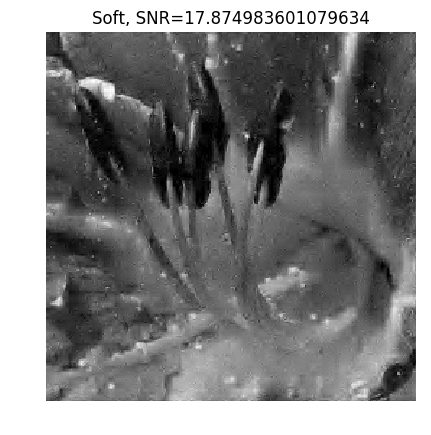

PyObject <matplotlib.text.Text object at 0x00000000276D8128>

In [20]:
imageplot(clamP(fSoft), string("Soft, SNR=", string(snr(f0, fSoft))) )

One can prove that if the non-linear approximation error 
$ \norm{f_0-S_T(f_0)}^2 $ decays fast toward zero when 
$T$ decreases, then the quadratic risk 
$ \EE_w( \norm{f-S_T(f)}^2 ) $ also decays fast to zero 
when $\si$ decays. For this result to hold, it is required
to select the threshold value according to the universal threshold rule
$$ T = \si \sqrt{2\log(N)}. $$

Determine the best threshold $T$ for both hard and soft thresholding.
Test several \(T\) values in $[.8\sigma, 4.5\sigma[$, 
and display the empirical SNR $-10\log_{10}(\norm{f_0-\tilde f}/\norm{f_0})$
What can you conclude from these results ? Test with another image.

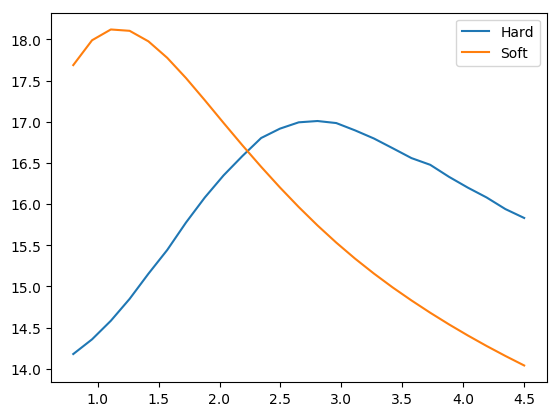

PyObject <matplotlib.legend.Legend object at 0x0000000027BF7978>

In [21]:
include("NtSolutions/denoisingwav_2_wavelet_2d/exo1.jl")

## Translation Invariant Denoising with Cycle Spinning

Orthogonal wavelet transforms are not translation invariant.
It means that the processing of an image and of a translated version of
the image give different results.

Any denoiser can be turned into a translation invariant denoiser by
performing a cycle spinning. The denoiser is applied to several shifted
copies of the image, then the resulting denoised image are shifted back
to the original position, and the results are averaged.

This corresponds to defining the estimator as
$$ \tilde f = \frac{1}{M} \sum_{i=1}^{M}$
      T_{-\de_i} \circ S_T(f) \circ T_{\de_i}$$
where $S_T$ is either the hard or soft thresholding, 
and $T_\de(f)(x) = f(x-\de)$ is the translation operator, 
using periodic boundary conditions. 
Here $(\de_i)_i$ is a set of $M$ discrete translation. Perfect invariance
is obtained by using all possible $N$ translatation, but 
usually a small number $M \ll N$ of translation is used to obtain approximate
invariance.

Number $m$ of translations along each direction
so that $M = m^2$. 

In [22]:
m = 4;

4

Generate a set of shifts $(\de_i)_i$.

In [23]:
include("NtToolBox/src/ndgrid.jl")
(dY, dX) = meshgrid(0:m-1, 0:m-1)
delta = cat(2, reshape(dX, m*m, 1), reshape(dY, m*m, 1));

16×2 Array{Int64,2}:
 0  0
 1  0
 2  0
 3  0
 0  1
 1  1
 2  1
 3  1
 0  2
 1  2
 2  2
 3  2
 0  3
 1  3
 2  3
 3  3

To avoid storing all the translates in memory, one can perform a
progressive averaging of the translates by defining $f^{(0)}=0$ and
then
$$ \forall\, i=1,\ldots,M, \quad f^{(i)} = \pa{1-\frac{i}{n}} f^{(i-1)} + 
      \frac{i}{n} T_{-\de_i} \circ S_T(f) \circ T_{\de_i}  $$
One then has $\tilde f = f^{(M)} $ after $M$ steps.

Initialize the denoised image $f^{(0)}=0$.

In [24]:
fTI = zeros(n, n)
T = 3*sigma
index = 1
for i in 1:m*m
    fS = circshift(f, delta[i, :])
    a = perform_wavortho_transf(fS, Jmin, 1, h)
    aT = thresh_hard(a, T)
    fS = perform_wavortho_transf(aT, Jmin, -1, h)
    fS = circshift(fS, -delta[i, :])
    fTI = i/(i + 1.0).*fTI + 1.0/(i + 1).*fS
    index += 1
end

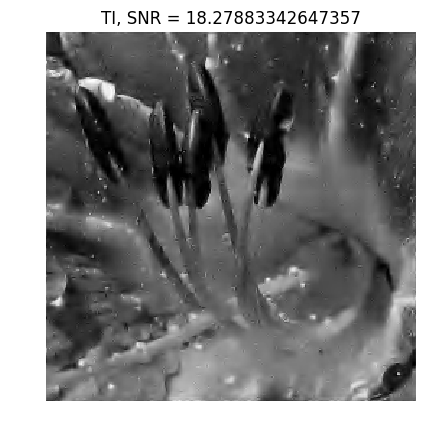

PyObject <matplotlib.text.Text object at 0x0000000027288A20>

In [25]:
imageplot(clamP(fTI), string("TI, SNR = ", string(snr(f0,fTI))) )

# Exercises

*Exercise 1:* Study the influence of the number $m$ of shift on the denoising
quality.

*Exercise 2:* Select the best threshold $T$ for the translation invariant denoising.

*Exercise 3:* Implement a block-thresholding method, that threshold coefficient in square blocks according to the energy of each of these blocks.